# Partie 2: Méthodes de la moyenne simple et de la moyenne exponentielle

In [96]:
!pip install yfinance
!pip install pandas_datareader

In [97]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
from matplotlib import gridspec

## ACTION APPLE

In [98]:
action_nom = 'AAPL'
data = yf.download(tickers=action_nom, start='2012-01-01', end='2023-01-29')
data.head(5)
#data.index

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.449689,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.516599,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.655555,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.787854,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.767570,394024400


### Remarque: 
Nous utilisons ici les prix de cloture ajusté 'Adj Close' plutôt que 'Close' afin d'obtenir une vision plus précise des performances de l'actif sur une période donnée, car les ajustements éliminent les distorsions potentielles créées par des événements corporatifs tels que les dividendes, les scissions d'actions, etc., qui peuvent affecter les prix des actions.

## MOYENNE MOBILE SIMPLE

### Description:
Ici on expérimente une méthode de prévision classique, très simple et assez basique. Il s'agit de la méthode de la moyenne mobile. L'idée ici est de se dire qu'on pourrait prédire les cours boursiers des jours à venir comme étant la moyenne de cours boursiers observées précédemment. Cela signifie que chaque valeur de la moyenne mobile est la moyenne des observations qui se trouvent dans la fenêtre à ce moment-là.

#### Formule : 
La moyenne mobile simple pour un instant t avec une fenêtre de taille n est la suivante :

SMAt​= (Xt−1​ + Xt−2​ + … + Xt−n)/n​​

Où :

    SMAt​ est la moyenne mobile simple à l'instant t,
    Xt−i​ sont les valeurs de la série temporelle à des instants antérieurs,
    n est la taille de la fenêtre de la moyenne mobile.

In [100]:
# Paramètres initiaux
taille_fenetre = 100
N = len(data) # on prend la taille de l'echantillon, ou encore la longueur du dataframe
predictions_moyenne_mobile = [] # liste vide pour stocker les prédictions de la moyenne
dates_predictions = [] # liste vide pour stocker les dates correspondant aux prédictions
erreurs_mse = [] # liste vide pour stocker les erreurs quadratiques moyenne

# Boucle principale
# On commence à prendre un indice de valeur la taille de la fenetre, on commence par cette dernière parceque l'objectif est
# de regarder à chaque itération les 'taille_fenetre' valeurs précédentes. On mémorise ensuite la date correspondant à l'indice
# et ensuite on regarde la date de début donnant la fenetre. On fait ensuite la moyenne sur cette période et on calcule l'erreur 
# qudratique avec la vraie valeur.

for pred_idx in range(taille_fenetre, N):
    date = data.index[pred_idx]  # Accéder à l'index comme date
    debut_fenetre = pred_idx - taille_fenetre
    fin_fenetre = pred_idx
    prediction = np.mean(data['Adj Close'].iloc[debut_fenetre:fin_fenetre])

    predictions_moyenne_mobile.append(prediction)
    erreur = prediction - data['Adj Close'].iloc[pred_idx]
    erreurs_mse.append(erreur ** 2)
    dates_predictions.append(date)

# Calcul de l'erreur quadratique moyenne (MSE)
mse = 0.5 * np.mean(erreurs_mse)
print(f'Erreur MSE pour la moyenne mobile standard : {mse:.5f}')

Erreur MSE pour la moyenne mobile standard : 29.55463


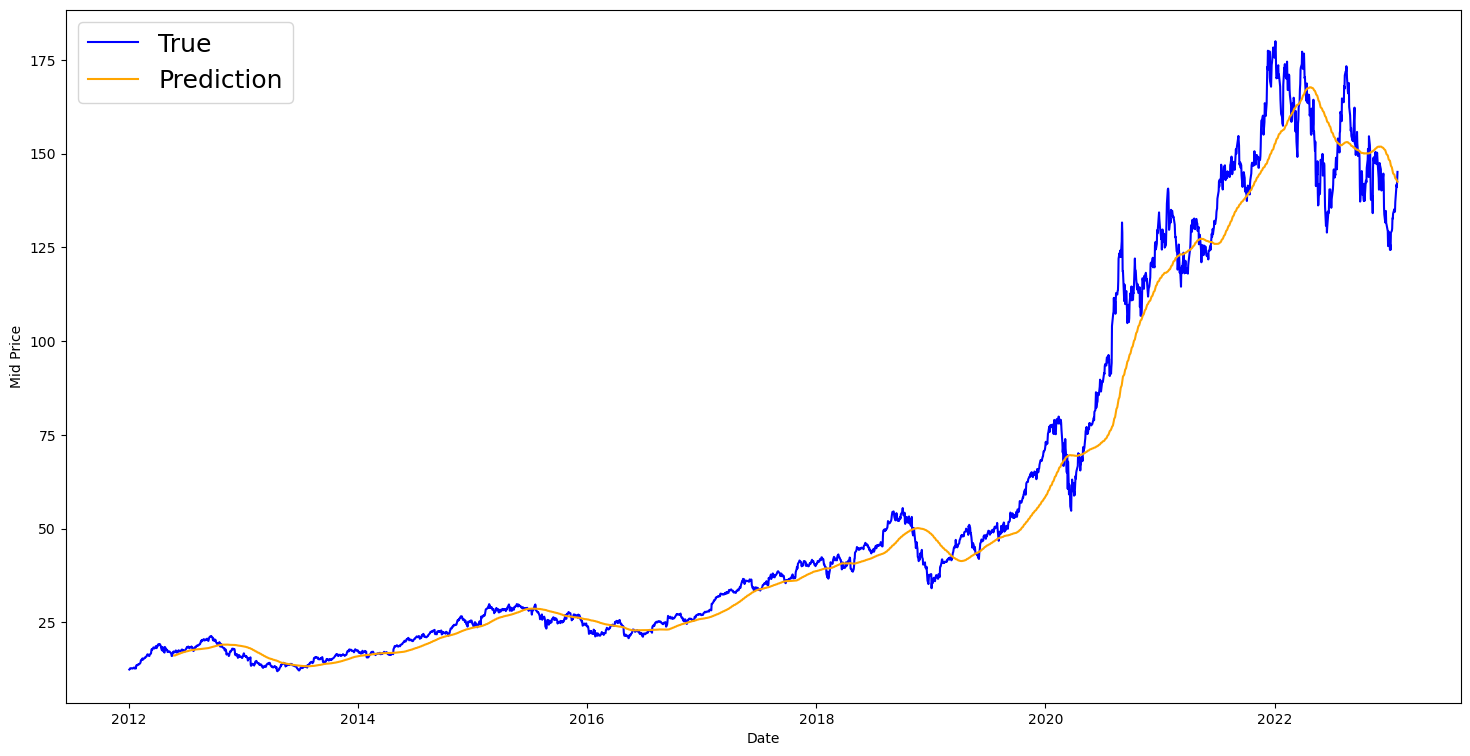

In [101]:
# Affichage des graphiques
plt.figure(figsize=(18, 9))
plt.plot(data.index, data['Adj Close'], color='b', label='True')
plt.plot(data.index[taille_fenetre:], predictions_moyenne_mobile, color='orange', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

On observe ici que les résultats moyens suivent bien le cours de l'action Apple. Puisque les cours en bourse ne changent pas de 0 à 100 du jour au lendemain, ce comportement est raisonnable.

### Avantages : 
La moyenne mobile lisse les variations à court terme et met davantage l'accent sur les tendances à long terme. Elle est simple à comprendre et à calculer.

### Limites : 
Elle réagit lentement aux changements récents, car elle donne un poids égal à toutes les observations dans la fenêtre, indépendamment de leur distance temporelle par rapport à la date actuelle. Elle peut être retardée dans la détection des changements de tendance.



## MOYENNE MOBILE EXPONENTIELLE (EMA)

### Description:
Nous allons appliquer ici une méthode similaire à la methode de la moyenne mobile simple dite de la moyenne mobile exponentielle. L'idée ici est de se dire que les jours précédents directement le jour dont on veut prédire la valeur de l'action la veille ou l'avant veille par exemple, ont une plus grande importance que les jours beaucoup plus éloignés. 
Une manière très interessante d'illustrer cette intuition est de donner aux jours de notre fenetre des poids différents en fonction de leurs 'proximité' au jour d'intérêt. Cela signifie qu'on attribue des poids décroissants aux observations à mesure qu'elles s'éloignent dans le temps. Cela est souvent formulé comme une combinaison pondérée exponentielle des observations précédentes.

### La formule générale de l'EMA est la suivante :
    EMAt=(1−α) × EMAt−1 + α × Observationt

    Où :

    EMAt​ est la valeur de l'EMA à l'instant t,
    EMAt−1​ est la valeur de l'EMA à l'instant t−1,
    Observationt​ est la nouvelle observation à l'instant t,
    α est le paramètre de lissage, également appelé facteur d'actualisation.

Le paramètre α détermine la rapidité avec laquelle l'EMA réagit aux changements dans les observations. Plus α est proche de 1, plus l'EMA sera réactif aux observations récentes. En finance, une valeur courante pour α est souvent de 2/(n+1), où n est la période de l'EMA ou ici la taille de la fenètre.

In [102]:
# Paramètres initiaux
taille_fenetre = 100
alpha = 2 / (taille_fenetre + 1)  # Paramètre alpha pour la moyenne exponentielle
N = len(data)
predictions_ema = []
dates_predictions = []
erreurs_mse = []

# Initialisation de la moyenne exponentielle avec la première valeur
ema = data['Adj Close'].iloc[:taille_fenetre].mean()

# Boucle principale
for pred_idx in range(taille_fenetre, N):
    date = data.index[pred_idx]  # Accéder à l'index comme date
    valeur_actuelle = data['Adj Close'].iloc[pred_idx]

    # Calcul de la moyenne exponentielle
    ema = alpha * valeur_actuelle + (1 - alpha) * ema

    predictions_ema.append(ema)
    erreur = ema - valeur_actuelle
    erreurs_mse.append(erreur ** 2)
    dates_predictions.append(date)

# Calcul de l'erreur quadratique moyenne (MSE)
mse = 0.5 * np.mean(erreurs_mse)
print(f'Erreur MSE pour la moyenne exponentielle mobile : {mse:.5f}')

# Création d'un DataFrame pour la visualisation
predictions_data = pd.DataFrame({'Date': dates_predictions, 'EMA_Prediction': predictions_ema})
predictions_data.set_index('Date', inplace=True)


Erreur MSE pour la moyenne exponentielle mobile : 22.99013


On remarque qu'on a un erreur plus faible avec le modele exponentielle pour une fenetre de 100 valeurs qu'avec le modele de moyenne simple!

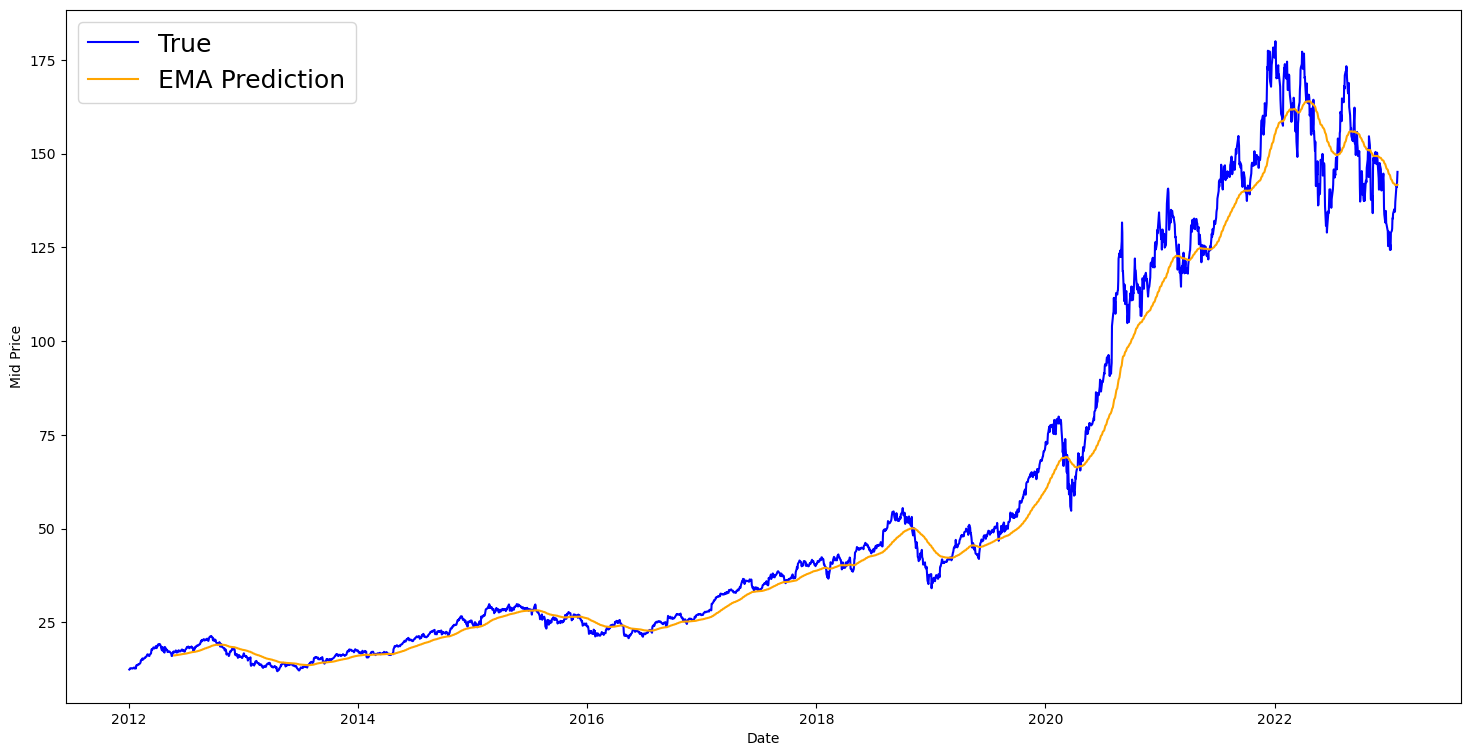

In [103]:
# Affichage des graphiques
plt.figure(figsize=(18, 9))
plt.plot(data.index, data['Adj Close'], color='b', label='True')
plt.plot(predictions_data.index, predictions_data['EMA_Prediction'], color='orange', label='EMA Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

### Si la moyenne exponentielle est si éfficace pourquoi n'est elle pas la plus utilisée? 

### Avantages : 
La moyenne mobile lisse les variations à court terme et met davantage l'accent sur les tendances à long terme. Elle est simple à comprendre et à calculer.

### Limites : 
Elle réagit lentement aux changements récents, car elle donne un poids égal à toutes les observations dans la fenêtre, indépendamment de leur distance temporelle par rapport à la date actuelle. Elle peut être retardée dans la détection des changements de tendance.

## Autres alternatives

En raison de ces limites, Ces modèles sont souvent utilisés comme des éléments d'une stratégie globale plutôt que comme des outils autonomes pour anticiper la volatilité. Les méthodes plus avancées, telles que les modèles GARCH (Generalized Autoregressive Conditional Heteroskedasticity), sont souvent préférées pour modéliser la volatilité, car elles sont conçues pour mieux capturer les propriétés dynamiques complexes des marchés financiers. Les modèles GARCH intègrent la dépendance conditionnelle et ajustent la volatilité en fonction des nouvelles informations disponibles, leur conférant plus de flexibilité et d'adaptabilité. Nous nous interesserons spécifiquement à cette méthode dans la suite du projet.

# Volatilité avec la moyenne mobile exponentielle (EMA)

La volatilité des cours boursiers est une mesure cruciale dans le monde financier, reflétant l'ampleur des variations de prix d'un actif financier sur une période donnée. C'est comme le rythme cardiaque des marchés, indiquant le degré d'agitation ou de stabilité. La volatilité conditionnelle, au cœur de notre analyse, s'attarde sur la nature changeante de cette mesure, reconnaissant que les marchés financiers sont dynamiques et que la volatilité peut fluctuer au fil du temps en réponse aux conditions du marché. Pour estimer cette volatilité conditionnelle, nous avons recours dans cette partie à l'Exponential Moving Average (EMA) utilisé plus haut pour prédire les cours boursiers. 

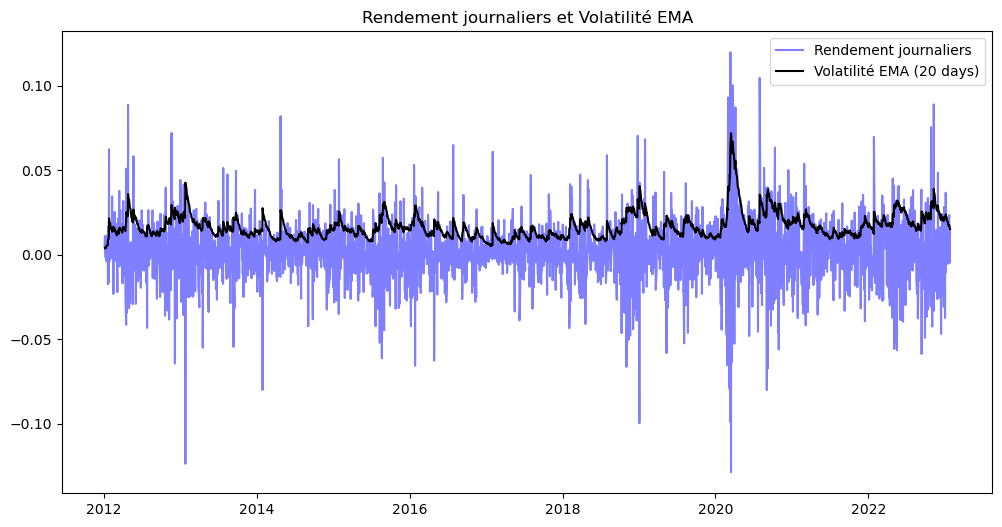

In [104]:
# Calcule des rendements quotidiens 
# On utilise la méthode pct.change() dont le but est de calculer le pourcentage de changement entre les éléments 
# successifs d'une série ou d'un DataFrame ce qui correspond ici au rendement journalier de l'action.
data['Rendement_journalier'] = data['Adj Close'].pct_change()

# Calcule de l'EMA sur une période de 20 jours en utilisant la méthode ewn 
data['Volatilité_EMA'] = data['Rendement_journalier'].ewm(span=20, adjust=False).std()

# Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(data['Rendement_journalier'], label='Rendement journaliers', alpha=0.5, color='blue')
plt.plot(data['Volatilité_EMA'], label='Volatilité EMA (20 days)', color='black')
plt.legend()
plt.title('Rendement journaliers et Volatilité EMA')
plt.show()

### Avantages

L'Exponential Moving Average (EMA) offre plusieurs avantages lorsqu'elle est utilisée pour prédire la volatilité des cours 
boursiers. Tout d'abord, sa capacité à réagir rapidement aux changements récents dans les rendements en fait un outil précieux 
pour détecter rapidement les variations de la volatilité, offrant ainsi une vision en temps réel des mouvements du marché. De plus, l'EMA est simple à implémenter et ne nécessite pas une grande quantité de données historiques pour fournir des estimations 
significatives, ce qui la rend adaptée à des situations où l'observation des tendances à court terme est cruciale.  
La flexibilité  du paramètre de lissage (α) permet également aux analystes d'ajuster la réactivité de l'EMA en fonction de leurs préférences, offrant ainsi une adaptabilité à diverses conditions de marché.


### Limites

Cependant, l'utilisation de l'EMA pour prédire la volatilité n'est pas sans limites. L'une des principales préoccupations réside 
dans sa sensibilité aux paramètres, en particulier le choix de α, ce qui peut rendre l'estimation trop réactive ou, au contraire, trop lente. De plus, l'EMA ne capture pas toujours les événements rares ou extrêmes ou les queues de distribution, ce qui peut limiter sa  capacité à modéliser des situations de marché exceptionnelles. Par exemple, considérons une distribution des rendements où la plupart des jours présentent des variations faibles, mais de temps en temps, il y a un événement exceptionnel avec une forte volatilité. L'EMA pourrait ne pas réagir immédiatement à cet événement, car elle lisse les variations. Cela peut entraîner une sous-estimation de la volatilité pendant les périodes de calme et une surestimation pendant les périodes de volatilité extrême. Pour surmonter ces limites, des alternatives plus sophistiquées  telles que les modèles GARCH (Generalized Autoregressive Conditional Heteroskedasticity) peuvent être envisagées. Les modèles  GARCH offrent une modélisation plus robuste de la volatilité conditionnelle, prenant en compte la dynamique des rendements passés tout en permettant de capturer les caractéristiques spécifiques de la distribution des rendements. 